### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## Task 1 - Geocoding

In [2]:
park = pd.read_csv("data/manh_tickets_2019.csv.zip")
pluto = pd.read_csv("data/manh_pluto.csv")

### Implementation

For task 1, we first made a dictionary of all the major misspellings and abbreviations we found in the addresses and matched them to the abbreviation we wanted to use after transforming all strings to uppercase and dropping rows with missing address data. We changed:
- STREET to ST
- AVENUE to AVE
- EAST/WEST/SOUTH/NORTH to E/W/S/N
- 'PL\w?C\w?':
    - PLACE to PL
    - PLC to PL
- 'B.*WAY':
    - B WAY to BROADWAY
    - BWAY to BROADWAY
- SQUARE to SQ
- DRIVE to DR
- PLZ to PLAZA
- '(?<=\d)((ST|ND|RD|TH)|(-\d*)|([A-Z]))(?=\s)':
    - 1ST/2ND/3RD/4TH etc. to 1/2/3/4 etc.
    - 13-34 WILLIAMS AVE (for example) to 13 WILLIAMS AVE
    - 13A WILLIAMS AVE (for example) to 13 WILLIAMS AVE
- '(W|S|N|E)(?=\s(W|S|N|E)\s)':
    - 134W W BROADWAY (for example) to 134 W BROADWAY
    - W W BROADWAY (for example) to W BROADWAY
- 'B.*L.*V.*D':
    - BOULEVARD to BLVD
    - BLV to BLVD
- '(?<=\s)B\$':
    - 2098 FREDERICK DOUGLASS B (for example) to 2098 FREDERICK DOUGLASS BOULEVARD
- 'AMERIC.*\$':
    - AMERIC to AMER
    - AMERICA to AMER
    - AMERICAS to AMER
    
Then we looped through each key and value pair in the dictionary and used str.replace to replace any matches of the value in the string with the key. After that, we merged the resulting datasets resulting in 47.53% of the parked data geocoded. We then removed the unnecessary columns and drop. We discoved that some addresses had multiple precincts coded for the same address. To mitigate this issue, we dropped observations that contain "BROADWAY" since many of them were too general (covered more than 10 precincts) and kept all the other duplicates which would be served as "random noise" in the training phase.

In [3]:
# Drop missing values
park = park.dropna()
pluto = pluto.dropna()

# Convert to upper case
park['address'] = park['address'].str.upper()
pluto['address'] = pluto['address'].str.upper()

# Dictionary to store changes of address
switches = {'STREET': 'ST', 
            'AVENUE' : 'AVE', 
            'EAST' : 'E', 
            'WEST' : 'W', 
            'SOUTH' : 'S', 
            'NORTH' : 'N', 
            'PL\w?C\w?' : 'PL', 
            'B.*WAY': 'BROADWAY', 
            'SQUARE' : 'SQ', 
            'DRIVE': 'DR', 
            'PLZ': 'PLAZA',
            '(?<=\d)((ST|ND|RD|TH)|(-\d*)|([A-Z]))(?=\s)': '',
            '(W|S|N|E)(?=\s(W|S|N|E)\s)': '',
            'B.*L.*V.*D': 'BLVD', 
            '(?<=\s)B$': 'BLVD',
            'AMERIC.*$' : 'AMER',
            }

# Replace original address
for key, val in switches.items():
    park['address'] = park['address'].str.replace(key, val, regex=True)
    pluto['address'] = pluto['address'].str.replace(key, val, regex=True)

In [4]:
# Merge the two datasets by cleaned address
merged_df = pd.merge(park, pluto, how='inner', on = 'address')

# 47.53% of the park data find matched
merged_df.shape[0] / park.shape[0]

0.4752836477695255

In [5]:
# Total of 1,769,991 observations
merged_df.shape

(1769991, 6)

In [6]:
# Drop unwanted columns
df = merged_df.drop(columns=['issue_date', 'violation_code'])

# Check how many addresses have multiple precinct
df['unique_precinct'] = df.groupby(['lat', 'long'])['precinct'].transform('nunique')
df.sort_values(by='unique_precinct', ascending=False).drop_duplicates(subset=['long', 'lat']).head(10)

,address,precinct,lat,long,unique_precinct
306153,W BROADWAY,20,40.720247,-74.005776,22
309674,W BROADWAY,14,40.717952,-74.007085,22
69127,E BROADWAY,24,40.714002,-73.988085,21
652044,700 COLUMBUS AVE,24,40.792037,-73.968642,12
366141,2412 BROADWAY,24,40.789884,-73.974825,11
549587,215 W 125 ST,28,40.809692,-73.948939,11
676514,55 5 AVE,6,40.734731,-73.994061,11
1419242,200 BROADWAY,13,40.710399,-74.008971,11
490269,511 W 125 ST,26,40.814027,-73.956417,11
234055,205 2 AVE,9,40.731634,-73.985899,10


In [7]:
# The addresses containing "BROADWAY" are too general, drop them
final_df = df.loc[~df.address.str.contains('BROADWAY')]
final_df.shape

(1647434, 5)

## Task 2 - Modeling

### Write up

For task 2, we started by creating points for Central Park. First we saved the latitude and longitude values of the four corners of the park. We then created a function to sample points in Central Park given the number of desired points and a random seed. The function first randomly generates the longitude values using a uniform distribution between the minimum and maximum longitude values. After that, we define a function called get_boundaries which, given the longitude value, finds the upper and lower bound of the latitude values based on the longitude and the boundary points for the latitude and returns these bounds. This step is necessary because the park is a generic parallelogram, not a rectangle. We then sample the latitudes uniformly within these bounds. The output of this function is a dataframe with the latitude and longitude pairs, the address coded as "Dummy," and the precinct coded as 22 (since Central Park is the 22nd precinct). We used the function to generate 50,000 points because that was approximately the median of the dataset. 

After creating the Central Park points, we split the data into a train set and a test set with 85% of the data in the train set and 15% in the test set. We tested Random Forest, KNN, and SVM. To tune the hyperparameters, we considered a grid search with stratified Cross-Validation. During training, we used both accuracy, precision, ROC/AUC (one vs. the other) metrics to analyze the results but found that they were choosing the same parameters in the grid search, so we only trained our final model using accuracy. We also tried adding a 2-degree polynomial feature with interaction only but the accuracy score was not better than just the original features. We chose KNN as our final model because it slighly outperformed the other models and was the fastest model by far, which makes it quicker to train and more efficient to implement with larger datasets. Below is a list of hyperparameters to be tuned with grid-search together with a range of values under consideration and the best parameter chosen in KNN:

- `n_neighbors`: Number of neighbors to use. The range of values is {45, 50, 55, 60, 65}. We considered these values because we didn't want it to be too small to avoid overfitting but at the same time it was not too computationally expensive. The best parameter value chosen is 60.
- `weights`: Weight function used in prediction. Range of values: {'uniform' (all points in each neighborhood are weighted equally), 'distance' (weight points by the inverse of their distance)}. These are the only available choices for `weights`. The best parameter is 'uniform'.

The test accuracy on the KNN model was 88.39%. The precision, recall, and f1-score for most precincts look good and the one vs. rest AUC score averaging across all precincts is pretty high, over 98%. The confusion matrix shows that the precinct is more likely to be misclassified as its neighbor(s) than other precincts that are far away. Overall there are not any precincts that are predicted particularly poorly,  We used a heatmap to visualize the confusion matrix as well.

### Implementation

In [8]:
# Make up points for Central Park precinct 22
# https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page
corners_lat = (40.768216, 40.764605, 40.800273, 40.796920)
corners_long = (-73.981290, -73.973110, -73.958046, -73.949786)

def sample_park_points(nsim, seed):
    rand = np.random.default_rng(seed)
    longitudes = rand.uniform(low=min(corners_long), high=max(corners_long), size=nsim)
    
    def get_boundaries(x):
        if x <= -73.973110:
            m_low = (40.764605 - 40.768216)/(-73.973110 + 73.981290)
            y_low = m_low*(x + 73.981290) + 40.768216
            
            m_high = (40.768216 - 40.800273)/(-73.981290 + 73.958046)
            y_high = m_high*(x + 73.981290) + 40.768216
            
        elif x <= -73.958046:
            m_low = (40.764605 - 40.796920)/(-73.973110 + 73.949786)
            y_low = m_low*(x + 73.973110) + 40.764605
            
            m_high = (40.768216 - 40.800273)/(-73.981290 + 73.958046)
            y_high = m_high*(x + 73.981290) + 40.768216
            
        else:
            m_low = (40.764605 - 40.796920)/(-73.973110 + 73.949786)
            y_low = m_low*(x + 73.973110) + 40.764605
            
            m_high = (40.796920 - 40.800273)/(-73.949786 + 73.958046)
            y_high = m_high*(x + 73.949786) + 40.796920
            
        return (y_low, y_high)
    
    lb = [get_boundaries(x)[0] for x in longitudes]
    ub = [get_boundaries(x)[1] for x in longitudes]
    
    latitudes = rand.uniform(low=lb, high=ub, size=nsim)
    
    out = pd.DataFrame(list(zip(latitudes, longitudes)), columns=['lat', 'long'])
    out['address'] = pd.Series(['Dummy' for x in range(len(out.index))])
    out['precinct'] = pd.Series([22 for x in range(len(out.index))])
    
    return out

In [9]:
# Check the distribution of number of observations in each precinct
final_df.groupby('precinct')['precinct'].count().describe()

count        22.000000
mean      74883.363636
std       62244.483166
min         148.000000
25%       35553.250000
50%       55919.500000
75%       88117.500000
max      261481.000000
Name: precinct, dtype: float64

In [10]:
# Generate 50000 observations, which is around the same as the median number of observations
central_park = sample_park_points(50000, 42)
central_park.head()

,lat,long,address,precinct
0,40.798308,-73.956907,Dummy,22
1,40.778579,-73.967464,Dummy,22
2,40.795637,-73.954241,Dummy,22
3,40.785795,-73.959320,Dummy,22
4,40.769753,-73.978323,Dummy,22


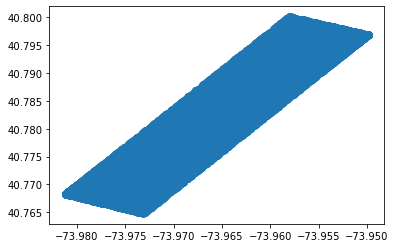

In [11]:
# Visualize the shape of generated data
plt.scatter(central_park.long, central_park.lat)
plt.show()

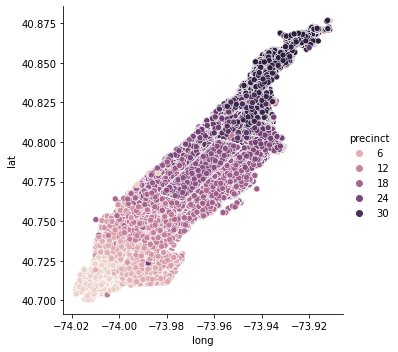

In [12]:
# Add "fake" data back to the final data
final_df = pd.concat([final_df, central_park], ignore_index=True)
# Visualize the locations of "fake" data
sns.relplot(x='long', y='lat', hue='precinct', data=final_df)
plt.show()

In [13]:
final_df = final_df.sort_values(by='precinct').reset_index(drop=True)
final_df.shape

(1697434, 5)

### Train-test split

In [14]:
train_df, test_df = train_test_split(final_df, test_size=0.15, random_state=42)

In [15]:
train_df.shape, test_df.shape

((1442818, 5), (254616, 5))

### Model - KNN

In [16]:
# Grid search to tune hyperparameters "n_neighbors" and "weights"
p = make_pipeline(KNeighborsClassifier())
knn_grid_search = GridSearchCV(
    p,
    param_grid = {
        "kneighborsclassifier__n_neighbors": [45, 50, 55, 60, 65],
        "kneighborsclassifier__weights": ['uniform', 'distance']
    },
    scoring = 'accuracy',
    cv = StratifiedKFold(shuffle=True, random_state=42))

knn_grid_search.fit(X = train_df[['long', 'lat']], y = train_df.precinct)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [45, 50, 55, 60,
                                                               65],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [17]:
# Best set of hyperparameters
knn_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 60,
 'kneighborsclassifier__weights': 'uniform'}

In [18]:
# Best CV Score in terms of accuracy
knn_grid_search.best_score_

0.8827925627275285

In [19]:
# Predict with test set
y_pred = knn_grid_search.predict(test_df[['long', 'lat']])
# Predict probability (to calculate AUC score) with test set
y_pred_prob = knn_grid_search.predict_proba(test_df[['long', 'lat']])

In [20]:
# Test accuracy
accuracy_score(test_df['precinct'], y_pred)

0.8840214283470009

In [21]:
# Classification report
report = classification_report(test_df['precinct'], y_pred, output_dict=True)
print(pd.DataFrame(report).round(4).transpose())

              precision  recall  f1-score     support
1                0.9475  0.9697    0.9585   15812.000
5                0.9228  0.9328    0.9278    9013.000
6                0.9435  0.9171    0.9301   13165.000
7                0.9454  0.9132    0.9290    5383.000
9                0.9510  0.9462    0.9486   11118.000
10               0.7912  0.7670    0.7789   11577.000
13               0.8684  0.8487    0.8584   23271.000
14               0.8207  0.8264    0.8235   24341.000
17               0.7913  0.7302    0.7595   13102.000
18               0.8266  0.8912    0.8577   23747.000
19               0.9657  0.9715    0.9686   39265.000
20               0.9314  0.9084    0.9198   12577.000
22               0.9999  0.9970    0.9984    7418.000
23               0.8938  0.7654    0.8246    7640.000
24               0.8357  0.8903    0.8622    7805.000
25               0.8042  0.8946    0.8470    5681.000
26               0.7899  0.6849    0.7337    2910.000
28               0.8109  0.8

In [22]:
# one vs. rest AUC score
roc_auc_score(test_df['precinct'], y_pred_prob, multi_class='ovr')

0.9875914128890433

In [23]:
# Confusion matrix for test data
confuse = confusion_matrix(test_df['precinct'], y_pred)

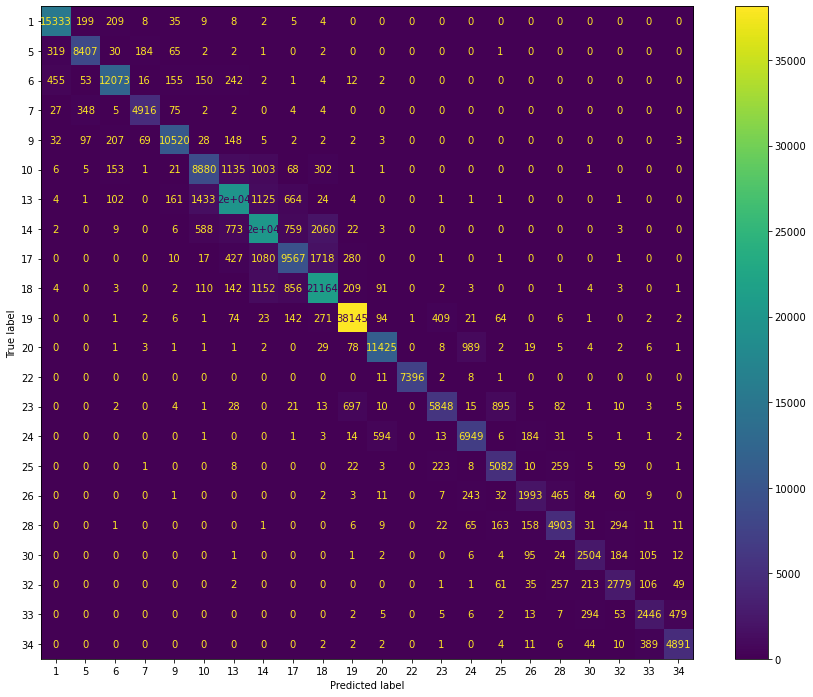

In [24]:
# Heatmap for confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix=confuse, display_labels=knn_grid_search.classes_)
fig, ax = plt.subplots(figsize=(15,12))
disp.plot(ax=ax)
plt.show()

## Task 3 - Visualization

In this task we predict both the locations in `manh_pred.csv` and the boundary points in `manh_bound.csv` using the KNN model we trained in Task 2. Then we made a scatter plot with longitude on the x-axis and latitude on the y-axis, colored by the predicted precincts. We also plot the original datapoints with black boundary as a comparison to the predicted points.

In [25]:
pred = pd.read_csv("data/manh_pred.csv")
bound = pd.read_csv("data/manh_bound.csv")

In [26]:
# Make predictions with the model trained in Task 2
preds = knn_grid_search.predict(pred[['long', 'lat']])
bound_pred = knn_grid_search.predict(bound[['long', 'lat']])

In [27]:
new_pred_df = pred.copy()
new_pred_df['precinct'] = preds
lat_medians = new_pred_df.groupby('precinct')['lat'].median()
long_medians = new_pred_df.groupby('precinct')['long'].median()

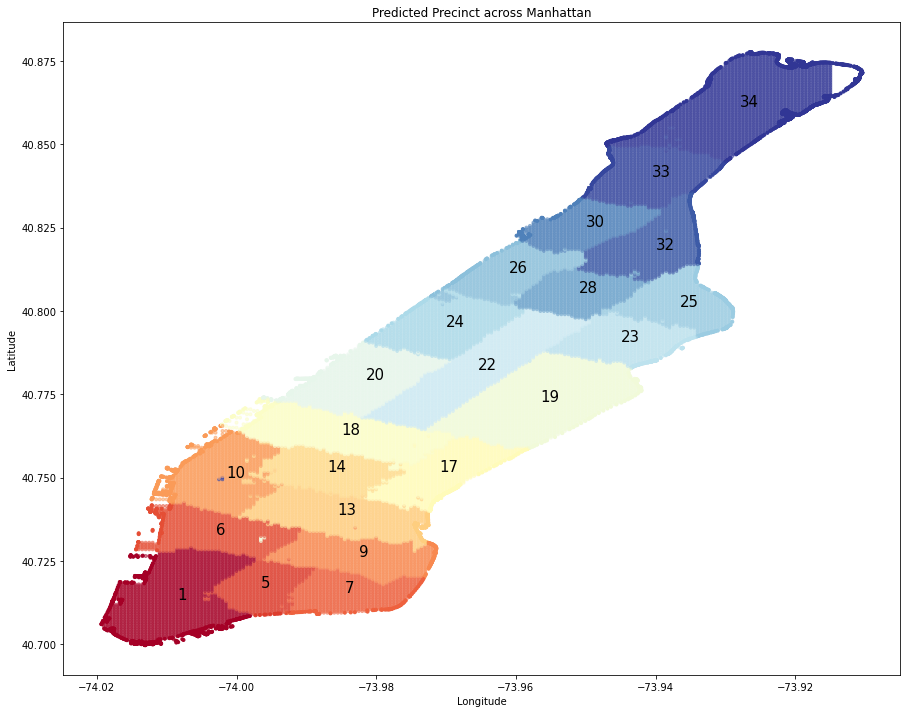

In [28]:
fig, ax = plt.subplots(figsize=(15,12))
# Plot boundary data colored by predicted precinct
scatter = ax.scatter(bound['long'], bound['lat'], c=bound_pred, cmap=plt.cm.RdYlBu, marker=".", alpha=1)
# Fill in with location data colored by predicted precinct
ax.scatter(pred['long'], pred['lat'], c=preds, cmap=plt.cm.RdYlBu, marker=".", alpha=0.5)
for long, lat, label in zip(long_medians, lat_medians, lat_medians.index.tolist()):
    ax.text(long, lat, label, fontdict=dict(color='black', size=15))
plt.title('Predicted Precinct across Manhattan')
plt.xlabel("Longitude")
plt.ylabel("Latitude");

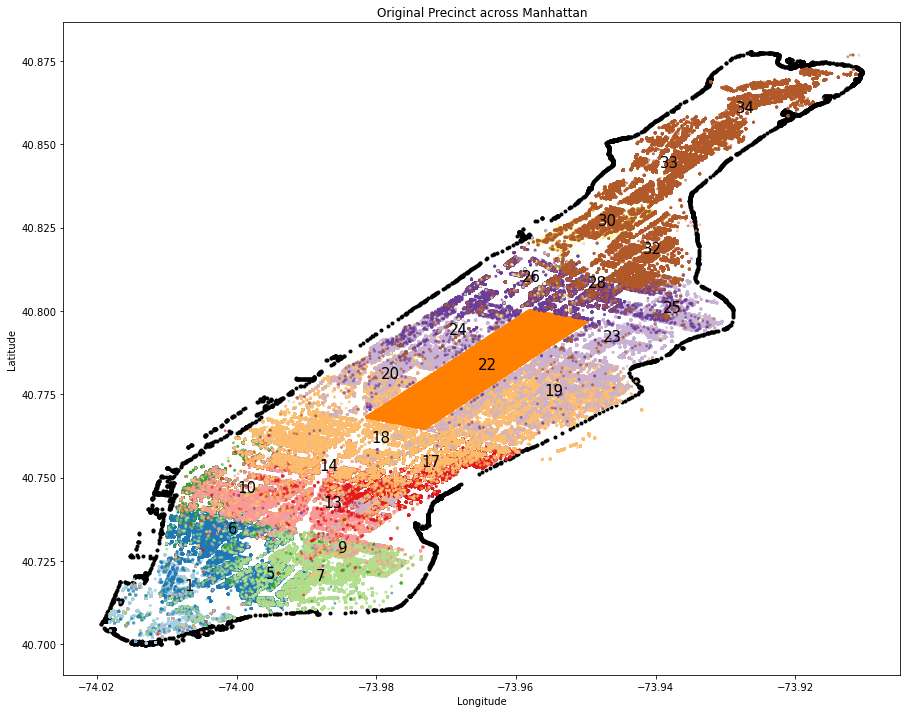

In [29]:
ori_lat_medians = final_df.groupby('precinct')['lat'].median()
ori_long_medians = final_df.groupby('precinct')['long'].median()

fig, ax = plt.subplots(figsize=(15,12))
# Plot boundary data in black
scatter = ax.scatter(bound['long'], bound['lat'], c='black', cmap=plt.cm.Paired, marker=".", alpha=1)
# Fill in with location data colored by original precinct
ax.scatter(x='long', y='lat', c='precinct', data=final_df, cmap=plt.cm.Paired, marker=".", alpha=0.5, s=15)
for long, lat, label in zip(ori_long_medians, ori_lat_medians, ori_lat_medians.index.tolist()):
    ax.text(long, lat, label, fontdict=dict(color='black', size=15))
plt.title('Original Precinct across Manhattan')
plt.xlabel("Longitude")
plt.ylabel("Latitude");